In [1]:
from __future__ import division

from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

import sphereml
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py
import lcmaes
from fitness_function import evaluate

import time
from joblib import Parallel, delayed
from persistence import save, load
import pyformulas as pf

factor=1.3					# area of plot

In [2]:
limitsdict = {'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}

def plot_hist(hist, label, linestyle='-'):
    histarr = np.array(hist)
    xs,ys = histarr[:,0],histarr[:,1]
    plt.plot(xs, ys, linestyle=linestyle, label=label)

In [3]:
def run_evaluation(algo, n_it, r_limits, m_limits, mj_limits, layers, evaluate=evaluate, 
                   popsize=None, sbbx_eta=1.0, elitepercent=.1,
                   log=True, seed=283636):
    def helper(ind):
        helper.calls += 1
        return evaluate(ind, layers=layers)
    helper.calls = 0
    
    hist = []
    limits = [r_limits]*layers+[m_limits,mj_limits]*layers+[(0.1, r_limits[-1]*factor)]
    
    if popsize is None: popsize = 5*len(limits)
    if popsize > n_it: raise AssertionError(f"popsize({popsize}) should be < n_it({n_it})")
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=popsize, limits=limits)
        for _ in range(int(n_it/popsize)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, -func(magic_cast(xk))))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=popsize, maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=popsize, generations=n_it, 
                            sbbx_eta=sbbx_eta, elitepercent=elitepercent, 
                            log=False, callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    elif algo == 'CMA':
        str_algo=b'acmaes'
        # the optimum should better not be far away from the interval [x0 - sigma0, x0 + sigma0] in each dimension
        
        lb = np.array(list(map(lambda t: t[0], limits)))
        rb = np.array(list(map(lambda t: t[1], limits)))
        x0 = list((rb + lb) / 2)
        #x0 = [7.30517923e+01, 6.80587508e+01, 6.76449791e+01, 1.20000000e+02,
        #      2.25222077e+01, 4.52804791e+00, 0.00000000e+00, 3.97006307e(+00,
        #      1.17444767e-01, 7.40650614e+00, 1.63541086e-01, 3.86546747e+00,
        #      1.18559092e-02, 9.37523459e+00, 3.06198400e-01, 1.42895581e+02]
        sigma0 = (rb.max() - lb.min()) / 3
        #sigma0 = 10
        print(f'sigma is {sigma0}')

        # without scaling (see lcmaes_interface.py). affects both parameters and optimization function
        gp = lcmaes.make_genopheno_pwqb(list(lb), list(rb), len(limits))
        p = lcmaes.make_parameters_pwqb(x0,sigma0,gp)
        p.set_str_algo(str_algo)
        #p.set_quiet(False)
        objfunc = lcmaes.fitfunc_pbf.from_callable(lambda x, n: -helper(x))
        
        def pfunc_raw(fitness):
            if np.isnan(fitness):
                return 0
            hist.append((helper.calls, -fitness))
            if helper.calls > n_it:
                #print("STOP")
                return 1
            return 0
        
        pfunc = lcmaes.pfunc_pbf.from_callable(pfunc_raw)
        
        results = lcmaes.pcmaes_pwqb2(objfunc, p, pfunc)
        bestie = results.best_candidate()
        
        fit, best = -bestie.get_fvalue(), lcmaes.get_candidate_x(bestie)
    else:
        raise AssertionError("Unknown algo")
    
    if log:
        print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

def run_evaluations(runs=50, *args, **kwargs):
    res = []
    for run in range(runs):
        _, _, hist = run_evaluation(*args, **kwargs)
        res.append(hist)
    return np.array(res)

In [7]:
best, _, hist = run_evaluation('JADE', n_it=1000, layers=2, sbbx_eta=0.5, log=False, **limitsdict)

In [8]:
best

array([4.32457046e+01, 1.19756852e+02, 7.15328279e+00, 1.28869179e-01,
       1.00000000e+01, 6.24843803e-02, 1.30965740e+02])

In [12]:
%%time
N_IT = 100000 # 5 min

res = {}
for sbbx_eta in [0.001, .01, .1, .5, 1.0, 1.5, 5.0, 10.0, 100.0]:
    print(f"sbbx_eta {sbbx_eta}")
    r = run_evaluations(runs=4, algo='genetic', n_it=N_IT, sbbx_eta=sbbx_eta, layers=2, log=False, **limitsdict)

    max_ = r[0]
    for cand in r:
        if cand[-1,1] > max_[-1,1]:
            max_=cand

    error = r.max(axis=0) - r.mean(axis=0)

    res[sbbx_eta] = (max_, error[:,1])
        
save(res, "results/genetic/sbbx_eta")

sbbx_eta 0.001
sbbx_eta 0.01
sbbx_eta 0.1
sbbx_eta 0.5
sbbx_eta 1.0
sbbx_eta 1.5
sbbx_eta 5.0
sbbx_eta 10.0
sbbx_eta 100.0
CPU times: user 3h 10min 15s, sys: 14.6 s, total: 3h 10min 29s
Wall time: 3h 9min 38s


In [8]:
%%time
N_IT = 100000 # 5 min

res = {}
for elitepercent in [.01, .0, .1]:
    print(f"elitepercent {elitepercent}")
    r = run_evaluations(runs=4, algo='genetic', n_it=N_IT, elitepercent=elitepercent, layers=2, log=False, **limitsdict)

    max_ = r[0]
    for cand in r:
        if cand[-1,1] > max_[-1,1]:
            max_=cand

    error = r.max(axis=0) - r.mean(axis=0)

    res[elitepercent] = (max_, error[:,1])
        
save(res, "results/genetic/elite")

elitepercent 0.01
elitepercent 0.0
elitepercent 0.1
CPU times: user 1h 7min 29s, sys: 846 ms, total: 1h 7min 30s
Wall time: 1h 7min 31s


In [5]:
%%time
N_IT = 100000 # 5 min

res = {}
layers=2
for popsize in [3 * (layers * 3 + 1), 5 * (layers * 3 + 1), 7 * (layers * 3 + 1), 10 * (layers * 3 + 1)]:
    print(f"popsize {popsize}")
    r = run_evaluations(runs=4, algo='genetic', n_it=N_IT, popsize=popsize, layers=layers, log=False, **limitsdict)

    max_ = r[0]
    for cand in r:
        if cand[-1,1] > max_[-1,1]:
            max_=cand

    error = r.max(axis=0) - r.mean(axis=0)

    res[popsize] = (max_, error[:,1])
        
save(res, "results/genetic/popsize")

popsize 21
popsize 35
popsize 49
popsize 70
CPU times: user 1h 25min 48s, sys: 4.27 s, total: 1h 25min 53s
Wall time: 1h 25min 37s


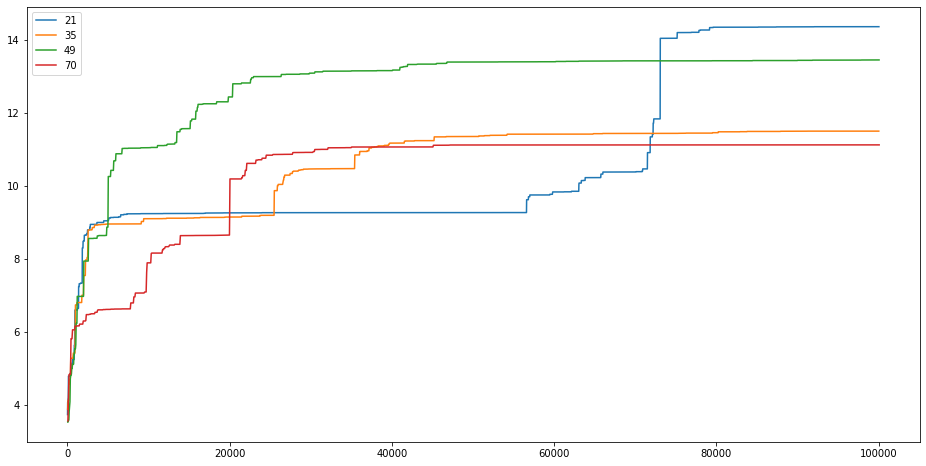

In [6]:
#res = load("results/genetic/sbbx_eta") # best are 0.1, 100, 0.001
res = load("results/genetic/popsize")
#res = load("results/genetic/elite") # best is 0.1
plt.figure(figsize=(16,8))
#for layers in res.keys():
layers=2
for key in res.keys():
    xs = res[key][0][:,0]
    ys = res[key][0][:,1]
    plt.plot(xs, ys, label=key)
plt.legend();